In [1]:
import numpy as np
import scipy
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [2]:
#creates dataframes train and test
df_train = pd.read_excel("Train.xlsx")
df_test = pd.read_excel("Test.xlsx")

# SOME DATA EXPLORATION

In [3]:
train_0 = df_train.loc[df_train['Income'] == 0] # Income = 0 - Rendimento =< da média
train_1 = df_train.loc[df_train['Income'] == 1] # Income = 1 - Rendimento > da média

In [4]:
print("Nº de pessoas com rendimento = 0:", len(train_0))
print("Nº de pessoas com rendimento = 1:", len(train_1))
print("% de pessoas com rendimento = 0:", len(train_0)/len(df_train)*100, "%")
print("% de pessoas com rendimento = 1:", len(train_1)/len(df_train)*100, "%")

Nº de pessoas com rendimento = 0: 17089
Nº de pessoas com rendimento = 1: 5311
% de pessoas com rendimento = 0: 76.29017857142857 %
% de pessoas com rendimento = 1: 23.709821428571427 %


In [5]:
print("% de pessoas com rendimento = 0 que receberam dinheiro:", len(train_0.loc[train_0['Money Received'] != 0])/len(train_0)*100, "%")
print("% de pessoas com rendimento = 1 que receberam dinheiro:", len(train_1.loc[train_1['Money Received'] != 0])/len(train_1)*100, "%")
print("% de pessoas com rendimento = 0 que pagaram bilhete:", len(train_0.loc[train_0['Ticket Price'] != 0])/len(train_0)*100, "%")
print("% de pessoas com rendimento = 1 que pagaram bilhete:", len(train_1.loc[train_1['Ticket Price'] != 0])/len(train_1)*100, "%")

% de pessoas com rendimento = 0 que receberam dinheiro: 4.160571127625958 %
% de pessoas com rendimento = 1 que receberam dinheiro: 21.107136132555073 %
% de pessoas com rendimento = 0 que pagaram bilhete: 3.025337936684417 %
% de pessoas com rendimento = 1 que pagaram bilhete: 10.167576727546601 %


In [6]:
print("% de pessoas que receberam dinheiro:", len(df_train.loc[df_train['Money Received'] != 0])/len(df_train)*100, "%")

% de pessoas que receberam dinheiro: 8.178571428571429 %


In [7]:
print("% de pessoas que pagaram dinheiro:", len(df_train.loc[df_train['Ticket Price'] != 0])/len(df_train)*100, "%")

% de pessoas que pagaram dinheiro: 4.71875 %


# DATA CLEANING

In [8]:
df_train[['Gender','Name']] = df_train.Name.str.split(" ", n=1, expand=True)

df_test[['Gender','Name']] = df_test.Name.str.split(" ", n=1, expand=True)

In [9]:
df_train["Gender"].unique() #Verificar os pronomes existentes ("Mr.", "Mrs." e "Miss")

array(['Mr.', 'Miss', 'Mrs.'], dtype=object)

In [10]:
df_train['Gender'].replace(['Miss', 'Mrs.', 'Mr.'], [0,0,1],inplace=True)
df_train = df_train.drop("Name", axis=1)

df_test['Gender'].replace(['Miss', 'Mrs.', 'Mr.'], [0,0,1],inplace=True)
df_test = df_test.drop("Name", axis=1)

In [11]:
#replaces index by ID of citizens; drops previous
df_train = df_train.set_index('CITIZEN_ID', drop=True)

df_test = df_test.set_index('CITIZEN_ID', drop=True)

In [12]:
#replaces ? with np.nan
df_train.replace('?', np.nan, inplace=True)

df_test.replace('?', np.nan, inplace=True)

In [13]:
#calculates age and drops birthay column
birthday = df_train["Birthday"].str.split(",", n=1, expand=True).rename(columns={0:"Day and month", 1:"Year"})
df_train = df_train.assign(Birthday=birthday['Year'])
df_train["Birthday"] = df_train["Birthday"].astype(int)
df_train["Birthday"] = 2048 - df_train["Birthday"]
df_train.rename(columns={'Birthday':'Age'}, inplace=True)

birthday = df_test["Birthday"].str.split(",", n=1, expand=True).rename(columns={0:"Day and month", 1:"Year"})
df_test = df_test.assign(Birthday=birthday['Year'])
df_test["Birthday"] = df_test["Birthday"].astype(int)
df_test["Birthday"] = 2048 - df_test["Birthday"]
df_test.rename(columns={'Birthday':'Age'}, inplace=True)

In [14]:
#merges money received and ticket price columns; people who payed have now a negative value in column "Money Received"
df_train["Money Received"] = -1 * df_train["Money Received"]
df_train['Ticket Price']= df_train['Money Received'] + df_train['Ticket Price']
del df_train['Money Received']

df_test["Money Received"] = -1 * df_test["Money Received"]
df_test['Ticket Price'] = df_test['Money Received'] + df_test['Ticket Price']
del df_test['Money Received']

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22400 entries, 12486 to 34885
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     22400 non-null  int64 
 1   Native Continent        22400 non-null  object
 2   Marital Status          22400 non-null  object
 3   Lives with              22400 non-null  object
 4   Base Area               22005 non-null  object
 5   Education Level         22400 non-null  object
 6   Years of Education      22400 non-null  int64 
 7   Employment Sector       21136 non-null  object
 8   Role                    21129 non-null  object
 9   Working Hours per week  22400 non-null  int64 
 10  Ticket Price            22400 non-null  int64 
 11  Income                  22400 non-null  int64 
 12  Gender                  22400 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 2.4+ MB


In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10100 entries, 34886 to 44985
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     10100 non-null  int64 
 1   Native Continent        10100 non-null  object
 2   Marital Status          10100 non-null  object
 3   Lives with              10100 non-null  object
 4   Base Area               9913 non-null   object
 5   Education Level         10100 non-null  object
 6   Years of Education      10100 non-null  int64 
 7   Employment Sector       9530 non-null   object
 8   Role                    9530 non-null   object
 9   Working Hours per week  10100 non-null  int64 
 10  Ticket Price            10100 non-null  int64 
 11  Gender                  10100 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 1.0+ MB


In [17]:
#checking unique values of categorical variables

In [18]:
df_train["Native Continent"].unique()

array(['Europe', 'Africa', 'Asia', 'America', 'Oceania'], dtype=object)

In [19]:
df_train["Native Continent"].value_counts()

Europe     19111
Africa      2187
Asia         699
America      219
Oceania      184
Name: Native Continent, dtype: int64

In [20]:
df_train["Marital Status"].unique()

array(['Married', 'Single', 'Married - Spouse Missing', 'Divorced',
       'Separated', 'Widow', 'Married - Spouse in the Army'], dtype=object)

In [21]:
#it's irrelevant to know if spouse is missing or in the army; even if it's relevant, this is such a small subset (284 and 14, respectively) that this has no power; thus, these values will be considered as just Married, and will thus be changed next:
df_train.loc[df_train["Marital Status"] == 'Married - Spouse Missing', "Marital Status"] = 'Married'
df_train.loc[df_train["Marital Status"] == 'Married - Spouse in the Army', "Marital Status"] = 'Married'

df_test.loc[df_test["Marital Status"] == 'Married - Spouse Missing', "Marital Status"] = 'Married'
df_test.loc[df_test["Marital Status"] == 'Married - Spouse in the Army', "Marital Status"] = 'Married'

df_train["Marital Status"].unique() #checks if sucessful

array(['Married', 'Single', 'Divorced', 'Separated', 'Widow'],
      dtype=object)

In [22]:
df_train["Lives with"].unique()

array(['Wife', 'Other Family', 'Children', 'Other relatives', 'Alone',
       'Husband'], dtype=object)

In [23]:
#it's irrelevant to know if it's "Wife" or "Husband", they're both "spouse", which will yield more statistical power to the instance, if relevant, and it's one less instance for One hot enconding, wich is good
df_train.loc[df_train["Lives with"] == 'Wife', "Lives with"] = 'Spouse'
df_train.loc[df_train["Lives with"] == 'Husband', "Lives with"] = 'Spouse'

df_test.loc[df_test["Lives with"] == 'Wife', "Lives with"] = 'Spouse'
df_test.loc[df_test["Lives with"] == 'Husband', "Lives with"] = 'Spouse'

df_train["Lives with"].unique() #checks if sucessful


array(['Spouse', 'Other Family', 'Children', 'Other relatives', 'Alone'],
      dtype=object)

In [24]:
df_train["Base Area"].unique() #irrelevant, especially coz they're from different continents, and we already have that info; I'd just drop it

array(['Northbury', 'Auchenshuggle', 'Sharnwick', 'Laewaes',
       'MillerVille', nan, 'Fanfoss', 'Wigston', "Knife's Edge",
       'Aerilon', 'Watford', 'Lanercost', 'Bellmoral', 'Marnmouth',
       'Bellenau', 'Butterpond', 'Laenteglos', 'Tranmere', 'Eelry',
       'Alverton', 'Pran', 'Willesden', "King's Watch", 'Kald',
       'Kirkwall', "Fool's March", 'Middlesbrough', 'Orilon',
       'Aroonshire', 'Aberuthven', 'Sharpton', 'Lewes', 'Mensfield',
       'Cherrytown', 'Redwick Bush', 'Drumchapel', 'Carlisle',
       'Conriston', 'Woodpine', 'Ironforge'], dtype=object)

In [25]:
df_train["Education Level"].unique() #will be dropped coz years of experience are more relevant; find way of showing that and then drop it

array(['High School + PostGraduation', 'Professional School',
       'High School - 2nd Cycle', 'PhD', 'Bachelors',
       'Bachelors + PostGraduation', 'Masters', 'High School - 1st Cycle',
       'High School Complete', 'Masters + PostGraduation',
       'Professional School + PostGraduation',
       'Middle School - 2nd Cycle', 'Middle School Complete',
       'Middle School - 1st Cycle', 'Primary School', 'Preschool'],
      dtype=object)

In [26]:
df_train["Education Level"].value_counts()

Professional School                     7232
High School + PostGraduation            4994
Bachelors + PostGraduation              3696
Masters                                 1193
Professional School + PostGraduation     953
High School - 2nd Cycle                  809
Bachelors                                735
High School - 1st Cycle                  649
Middle School - 2nd Cycle                432
Masters + PostGraduation                 397
Middle School Complete                   342
PhD                                      289
High School Complete                     287
Middle School - 1st Cycle                237
Primary School                           122
Preschool                                 33
Name: Education Level, dtype: int64

In [27]:
#will drop both FOR NOW just for the sake of having a working dataset ASAP; later will provide justification for this
df_train = df_train.drop("Base Area", axis=1)
df_train = df_train.drop("Education Level", axis=1)

df_test = df_test.drop("Base Area", axis=1)
df_test = df_test.drop("Education Level", axis=1)

In [28]:
#replaces nan with np.nan
df_train.replace('nan', np.nan, inplace=True)

df_test.replace('nan', np.nan, inplace=True)

In [29]:
df_train.describe()

,Age,Years of Education,Working Hours per week,Ticket Price,Income,Gender
count,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000
mean,38.584866,13.173884,40.483795,-1215.770045,0.237098,0.668348
std,13.651578,2.512451,12.370921,9256.954742,0.425313,0.470817
min,17.000000,2.000000,1.000000,-122999.000000,0.000000,0.000000
25%,28.000000,12.000000,40.000000,0.000000,0.000000,0.000000
50%,37.000000,13.000000,40.000000,0.000000,0.000000,1.000000
75%,48.000000,15.000000,45.000000,0.000000,0.000000,1.000000
max,90.000000,21.000000,99.000000,5358.000000,1.000000,1.000000


In [30]:
(df_train.groupby("Role")["Income"].sum() / df_train.groupby("Role")["Income"].count()).sort_values()

Role
Household Services                0.000000
Other services                    0.038916
Cleaners & Handlers               0.062907
Agriculture and Fishing           0.112536
Machine Operators & Inspectors    0.117775
Administratives                   0.138804
Transports                        0.196078
Army                              0.200000
Repair & constructions            0.221109
Sales                             0.261952
Security                          0.297778
IT                                0.298722
Professor                         0.444015
Management                        0.481230
Name: Income, dtype: float64

In [31]:
df_test["Employment Sector"].value_counts()

Private Sector - Services     7052
Self-Employed (Individual)     772
Public Sector - Others         672
Private Sector - Others        417
Self-Employed (Company)        349
Public Sector - Government     266
Unemployed                       2
Name: Employment Sector, dtype: int64

In [32]:
df_train["Employment Sector"].value_counts()

Private Sector - Services     15599
Self-Employed (Individual)     1764
Public Sector - Others         1419
Private Sector - Others         880
Self-Employed (Company)         763
Public Sector - Government      692
Unemployed                       12
Never Worked                      7
Name: Employment Sector, dtype: int64

In [33]:
df_train["Role"].unique()

array(['Repair & constructions', 'Sales', 'Security', 'Professor',
       'Cleaners & Handlers', 'Other services',
       'Machine Operators & Inspectors', 'Management', 'Administratives',
       'Transports', nan, 'Agriculture and Fishing', 'IT',
       'Household Services', 'Army'], dtype=object)

In [34]:
df_train["Role"].value_counts() #although this will give us 14 dummies / 14 columns through OHC, think it's important to maintain


Professor                         2849
Management                        2797
Repair & constructions            2795
Administratives                   2608
Sales                             2531
Other services                    2287
Machine Operators & Inspectors    1384
Transports                        1071
Cleaners & Handlers                922
Agriculture and Fishing            702
IT                                 626
Security                           450
Household Services                 102
Army                                 5
Name: Role, dtype: int64

In [35]:
# count of missing values for train
df_train.isna().sum()

Age                          0
Native Continent             0
Marital Status               0
Lives with                   0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Ticket Price                 0
Income                       0
Gender                       0
dtype: int64

In [36]:
# count of missing values for test
df_test.isna().sum()

Age                         0
Native Continent            0
Marital Status              0
Lives with                  0
Years of Education          0
Employment Sector         570
Role                      570
Working Hours per week      0
Ticket Price                0
Gender                      0
dtype: int64

In [37]:
#deals with missing values of both categorical values differently:

#feel comfortable replacing NaNs in 'Emplyment Sector' by mode coz vast majority of entries belong to same class, so this won't have a big impact
modes = df_train['Employment Sector'].mode().loc[0]
df_train['Employment Sector'].fillna(modes, inplace=True)

modes = df_test['Employment Sector'].mode().loc[0]
df_test['Employment Sector'].fillna(modes, inplace=True)

#since "Role" value_counts are so well distributed, we cannot simply replace missing values with mode; best solution here would be to create new categorical of "Unknown"
df_train['Role'].fillna('Unknown', inplace=True)

df_test['Role'].fillna('Unknown', inplace=True)

df_train.isna().sum() #checking how many NaNs we still have

Age                       0
Native Continent          0
Marital Status            0
Lives with                0
Years of Education        0
Employment Sector         0
Role                      0
Working Hours per week    0
Ticket Price              0
Income                    0
Gender                    0
dtype: int64

In [38]:
df_train

,Age,Native Continent,Marital Status,Lives with,Years of Education,Employment Sector,Role,Working Hours per week,Ticket Price,Income,Gender
CITIZEN_ID,,,,,,,,,,,
12486,45,Europe,Married,Spouse,13,Private Sector - Services,Repair & constructions,40,2273,1,1
12487,42,Europe,Married,Spouse,12,Public Sector - Others,Repair & constructions,40,0,1,1
12488,39,Europe,Married,Spouse,12,Private Sector - Services,Sales,46,2321,1,1
12489,63,Europe,Married,Spouse,11,Private Sector - Services,Security,37,-5395,1,1
12490,33,Europe,Single,Other Family,21,Self-Employed (Individual),Professor,45,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
34881,25,Europe,Divorced,Children,12,Private Sector - Services,Cleaners & Handlers,40,0,0,0
34882,23,Europe,Single,Children,12,Private Sector - Services,Other services,35,0,0,1
34883,26,Europe,Single,Other Family,17,Public Sector - Others,Professor,40,-2674,0,0


In [39]:
df_test

,Age,Native Continent,Marital Status,Lives with,Years of Education,Employment Sector,Role,Working Hours per week,Ticket Price,Gender
CITIZEN_ID,,,,,,,,,,
34886,36,Europe,Married,Spouse,16,Private Sector - Services,Sales,40,0,1
34887,34,Europe,Single,Other Family,16,Private Sector - Services,Professor,36,0,0
34888,28,Europe,Divorced,Other Family,13,Private Sector - Services,Management,50,-12940,1
34889,32,Europe,Married,Spouse,12,Private Sector - Services,Professor,48,1827,1
34890,37,Europe,Married,Spouse,15,Public Sector - Others,Professor,45,0,1
...,...,...,...,...,...,...,...,...,...,...
44981,36,Europe,Married,Spouse,17,Private Sector - Services,Professor,60,2432,1
44982,48,Europe,Divorced,Other Family,17,Private Sector - Services,Management,50,-122999,1
44983,26,Europe,Single,Alone,13,Public Sector - Government,Administratives,15,0,0


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

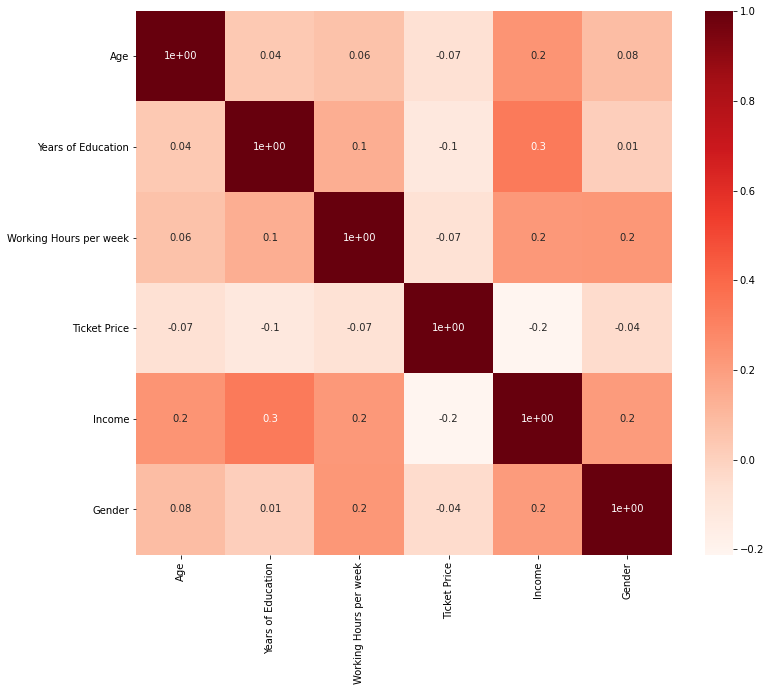

In [41]:
cor_pearson = df_train.corr()
cor_heatmap(cor_pearson)

In [42]:
#continuous variables don't seem to be highly correlated, let's mantain them all!

ONE-HOT ENCODING TO ENCODE CATEGORICAL VARIABLES

Note the following: after applying OHC, df_test is missing two columns: Income (expected) and 'x3_Private Sector - Services' - don't forget to deal with this later, otherwise issues will arise; this happened because "Never worked" is not present in the test dataset; thus, thus column will be merged with "Unemployed" in the train dataset to avoid further issues. Both of them are very low represented and probably have low predictive power, so this shouldn't be an issue.

In [43]:
df_train['Employment Sector'].replace('Never Worked', 'Not working', inplace = True)
df_train['Employment Sector'].replace('Unemployed', 'Not working', inplace = True)

In [44]:
df_train['Employment Sector'].unique()

array(['Private Sector - Services ', 'Public Sector - Others',
       'Self-Employed (Individual)', 'Private Sector - Others',
       'Self-Employed (Company)', 'Public Sector - Government',
       'Not working'], dtype=object)

In [45]:
df_ohc_train = df_train.copy()
df_ohc_test = df_test.copy()

In [46]:
non_metric_features = ['Native Continent', 'Marital Status', 'Lives with', 'Employment Sector', 'Role']

In [47]:
# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat_train = ohc.fit_transform(df_ohc_train[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df_train = pd.DataFrame(ohc_feat_train, index=df_ohc_train.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?

ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat_test = ohc.fit_transform(df_ohc_test[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df_test = pd.DataFrame(ohc_feat_test, index=df_ohc_test.index, columns=ohc_feat_names)


ohc_df_train #show train ohc

,x0_America,x0_Asia,x0_Europe,x0_Oceania,x1_Married,x1_Separated,x1_Single,x1_Widow,x2_Children,x2_Other Family,...,x4_IT,x4_Machine Operators & Inspectors,x4_Management,x4_Other services,x4_Professor,x4_Repair & constructions,x4_Sales,x4_Security,x4_Transports,x4_Unknown
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12487,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12488,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12489,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12490,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34881,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34882,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
34883,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# Reassigning df to contain ohc variables
df_ohc_train = pd.concat([df_ohc_train.drop(columns=non_metric_features), ohc_df_train], axis=1)

df_ohc_test = pd.concat([df_ohc_test.drop(columns=non_metric_features), ohc_df_test], axis=1)

df_ohc_train.head()

,Age,Years of Education,Working Hours per week,Ticket Price,Income,Gender,x0_America,x0_Asia,x0_Europe,x0_Oceania,...,x4_IT,x4_Machine Operators & Inspectors,x4_Management,x4_Other services,x4_Professor,x4_Repair & constructions,x4_Sales,x4_Security,x4_Transports,x4_Unknown
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,45,13,40,2273,1,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12487,42,12,40,0,1,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12488,39,12,46,2321,1,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12489,63,11,37,-5395,1,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12490,33,21,45,0,1,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [49]:
df_ohc_train.head()

,Age,Years of Education,Working Hours per week,Ticket Price,Income,Gender,x0_America,x0_Asia,x0_Europe,x0_Oceania,...,x4_IT,x4_Machine Operators & Inspectors,x4_Management,x4_Other services,x4_Professor,x4_Repair & constructions,x4_Sales,x4_Security,x4_Transports,x4_Unknown
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,45,13,40,2273,1,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12487,42,12,40,0,1,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12488,39,12,46,2321,1,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12489,63,11,37,-5395,1,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12490,33,21,45,0,1,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [50]:
df_ohc_test.head()

,Age,Years of Education,Working Hours per week,Ticket Price,Gender,x0_America,x0_Asia,x0_Europe,x0_Oceania,x1_Married,...,x4_IT,x4_Machine Operators & Inspectors,x4_Management,x4_Other services,x4_Professor,x4_Repair & constructions,x4_Sales,x4_Security,x4_Transports,x4_Unknown
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
34886,36,16,40,0,1,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
34887,34,16,36,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
34888,28,13,50,-12940,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34889,32,12,48,1827,1,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
34890,37,15,45,0,1,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# DEALING WITH OUTLIERS

In [51]:
numeric_variables = ['Age', 'Years of Education', 'Working Hours per week', 'Ticket Price']

In [52]:
df_outlier_train = df_ohc_train.copy()
df_outlier_test = df_ohc_test.copy()

In [53]:
#TRAIN

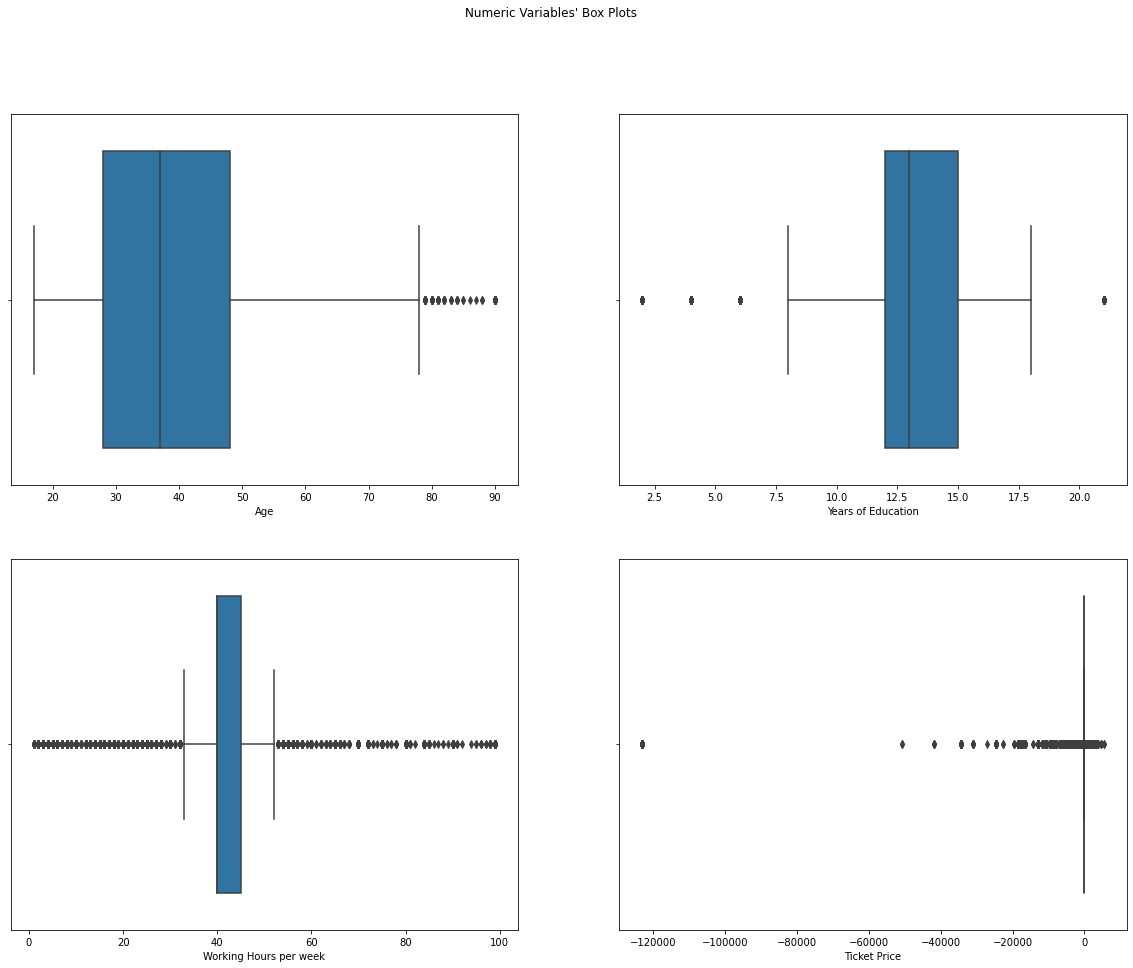

In [54]:
# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(numeric_variables) / 2), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), numeric_variables): # Notice the zip() function and flatten() method
    sns.boxplot(x=df_outlier_train[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

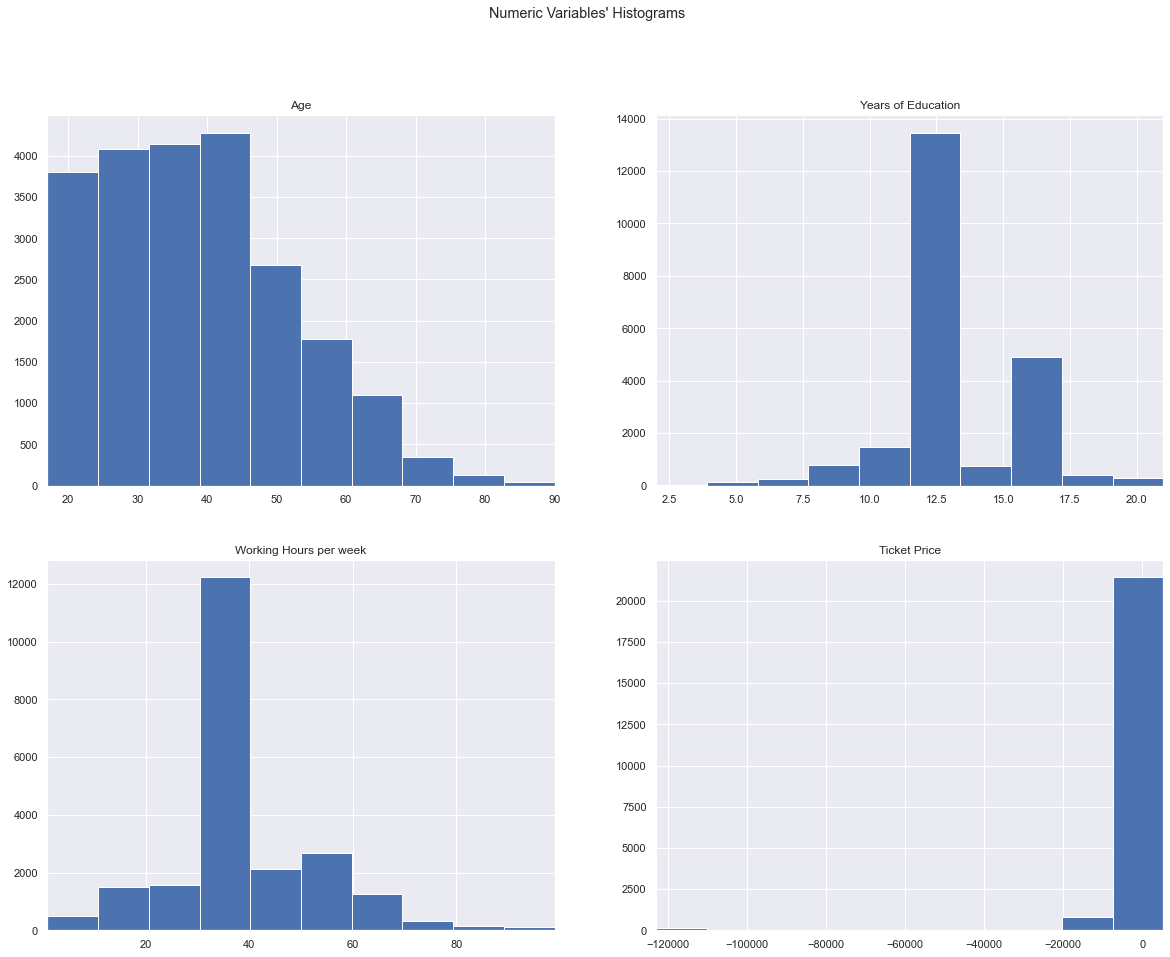

In [55]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(numeric_variables) / 2), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), numeric_variables): # Notice the zip() function and flatten() method
    ax.hist(df_outlier_train[feat])
    ax.set_title(feat)
    ax.set_xlim(min(df_outlier_train[feat]), max(df_outlier_train[feat]))
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

In [56]:
#Outliers will be removed manually as it visually there aren't many, except for one/few in ticket price; these will be removed; we do realize this method may be subjective, but given the nature of the data, we feel like this is a good approach for this dataset

filters1 = (df_outlier_train['Ticket Price']>=-20000)

df_outlier_train = df_outlier_train[filters1]

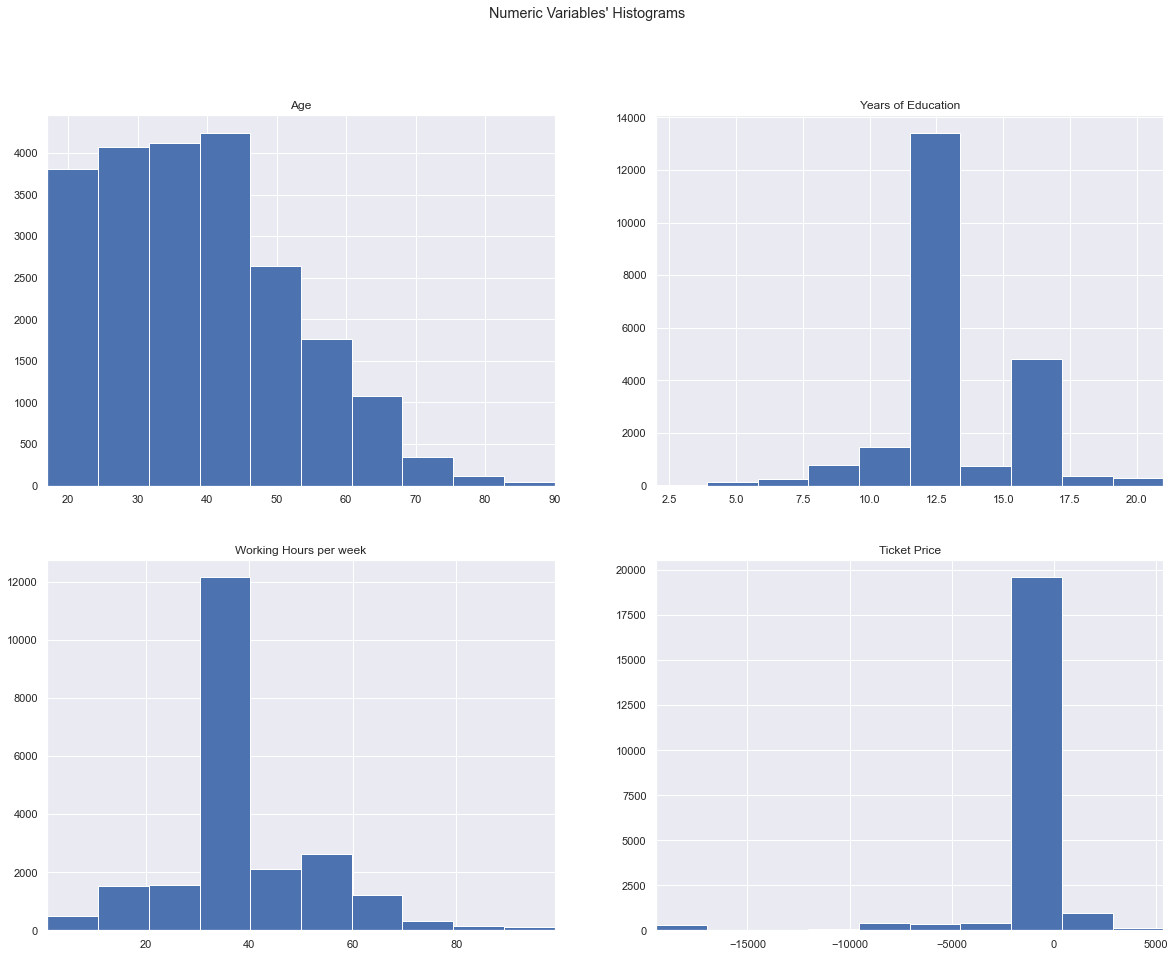

In [57]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(numeric_variables) / 2), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), numeric_variables): # Notice the zip() function and flatten() method
    ax.hist(df_outlier_train[feat])
    ax.set_title(feat)
    ax.set_xlim(min(df_outlier_train[feat]), max(df_outlier_train[feat]))
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

In [58]:
print('Proportion of data kept after removing outliers:', np.round(df_outlier_train.shape[0] / df_ohc_train.shape[0], 4))

Proportion of data kept after removing outliers: 0.9922


In [59]:
#TEST

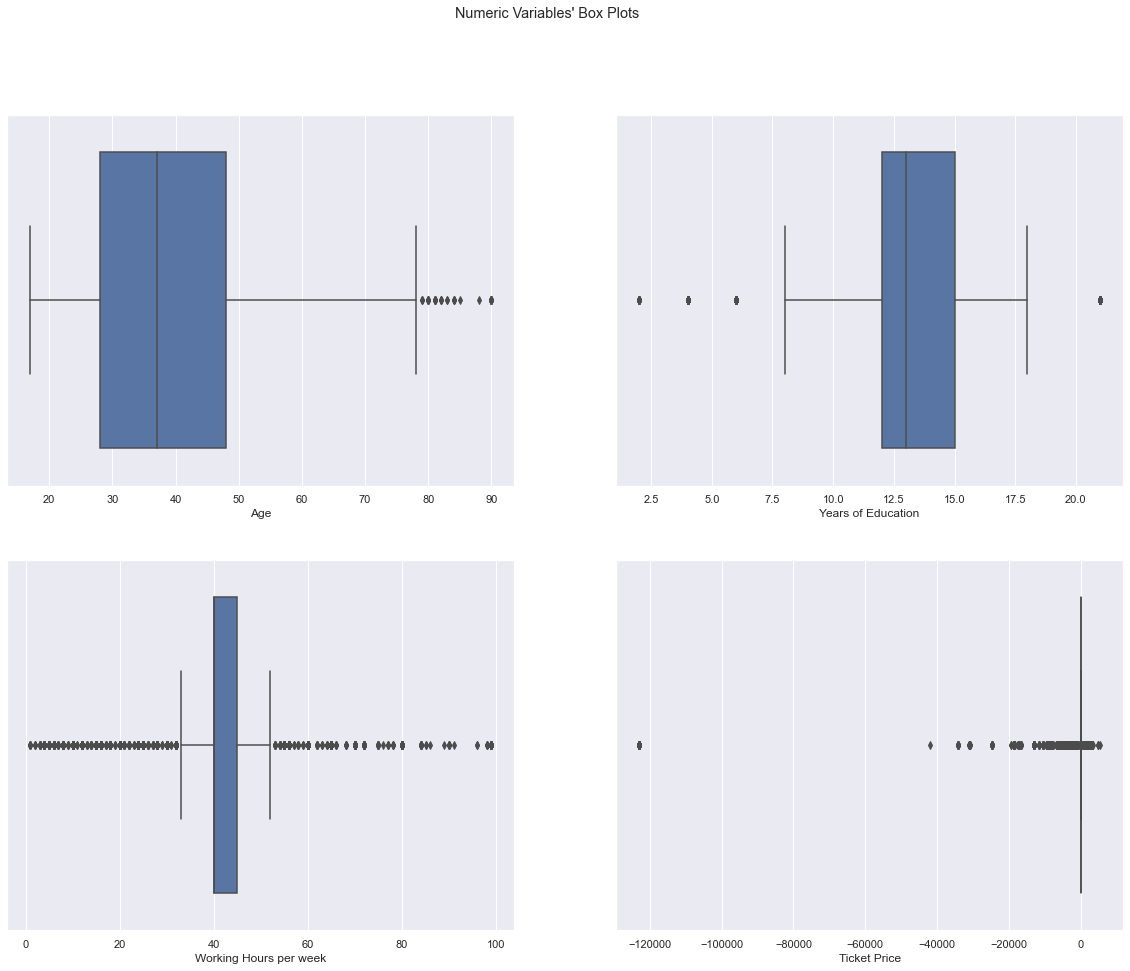

In [60]:
# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(numeric_variables) / 2), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), numeric_variables): # Notice the zip() function and flatten() method
    sns.boxplot(x=df_outlier_test[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

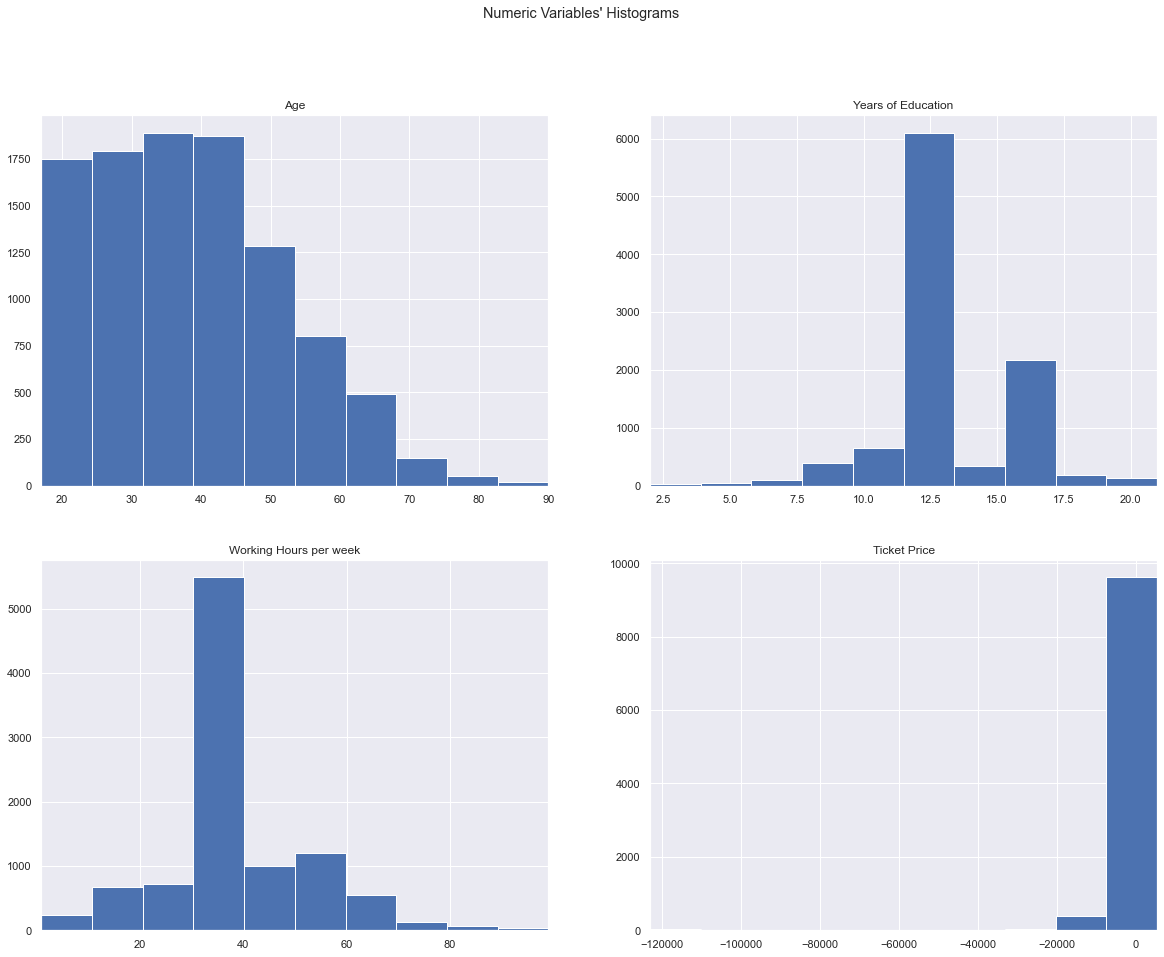

In [61]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(numeric_variables) / 2), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), numeric_variables): # Notice the zip() function and flatten() method
    ax.hist(df_outlier_test[feat])
    ax.set_title(feat)
    ax.set_xlim(min(df_outlier_test[feat]), max(df_outlier_test[feat]))
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

In [62]:
#Outliers will be removed manually as it visually there aren't many, except for one/few in ticket price; these will be removed; we do realize this method may be subjective, but given the nature of the data, we feel like this is a good approach for this dataset

filters1 = (df_outlier_test['Ticket Price']>=-20000)

df_outlier_test = df_outlier_test[filters1]

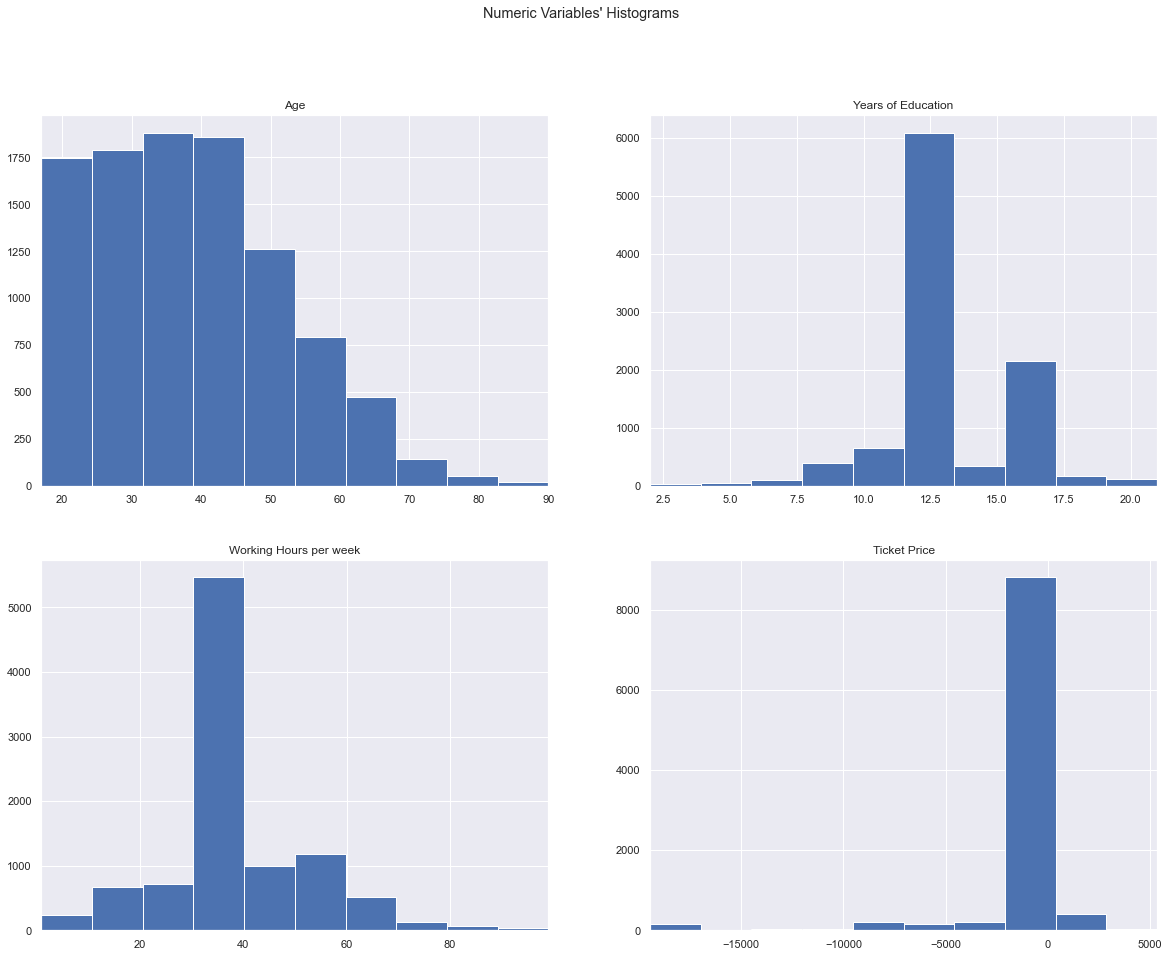

In [63]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(numeric_variables) / 2), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), numeric_variables): # Notice the zip() function and flatten() method
    ax.hist(df_outlier_test[feat])
    ax.set_title(feat)
    ax.set_xlim(min(df_outlier_test[feat]), max(df_outlier_test[feat]))
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

In [64]:
print('Proportion of data kept after removing outliers:', np.round(df_outlier_test.shape[0] / df_ohc_test.shape[0], 4))

Proportion of data kept after removing outliers: 0.992


# FEATURE SELECTION

In [65]:
non_metric_features = ['Native Continent', 'Marital Status', 'Lives with', 'Employment Sector', 'Role']

In [66]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="skyblue")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.xticks(rotation='vertical')
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="skyblue")
    plt.xticks(rotation='vertical')
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")

    plt.show()

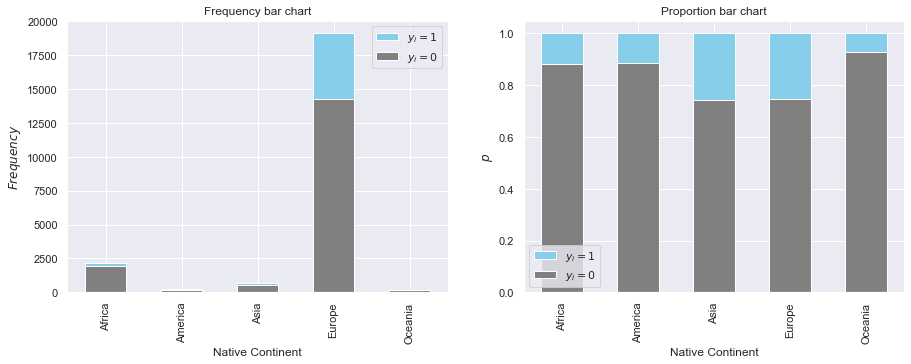

In [67]:
bar_charts_categorical(df_train, 'Native Continent', "Income")

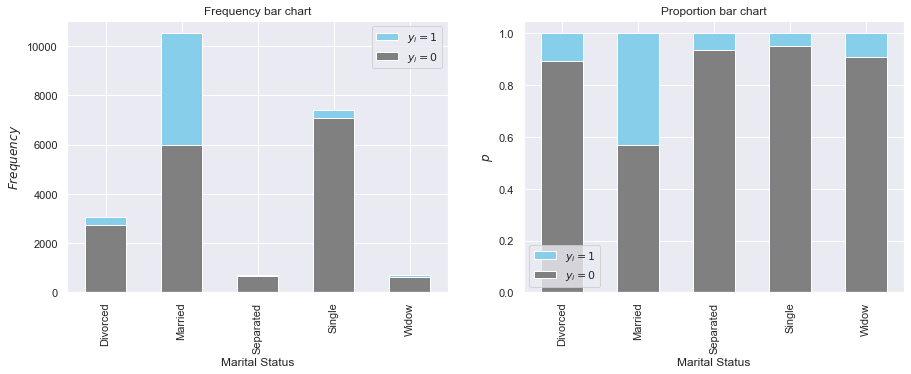

In [68]:
bar_charts_categorical(df_train, 'Marital Status', "Income")

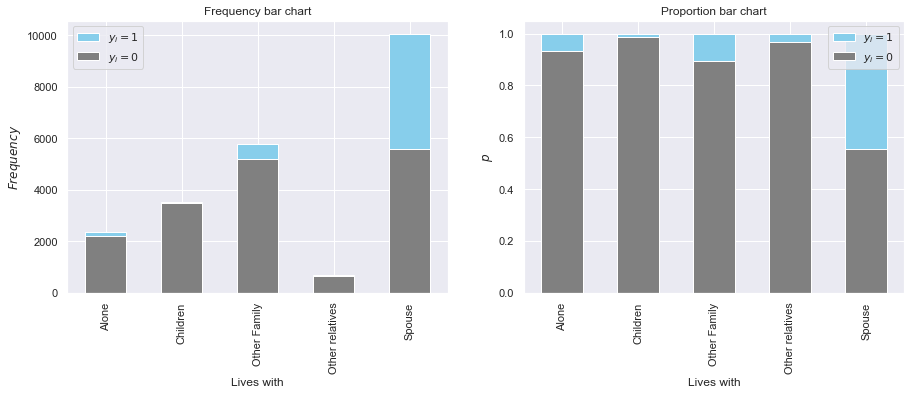

In [69]:
bar_charts_categorical(df_train, 'Lives with', "Income")

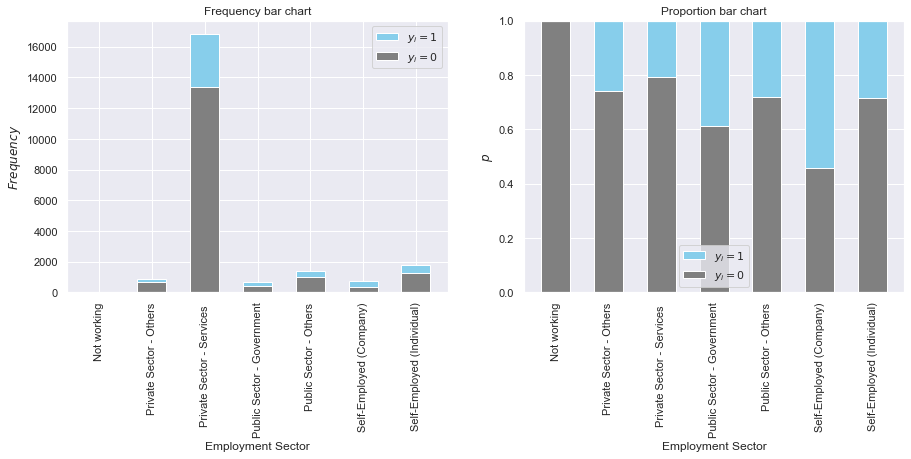

In [70]:
bar_charts_categorical(df_train, 'Employment Sector', "Income")

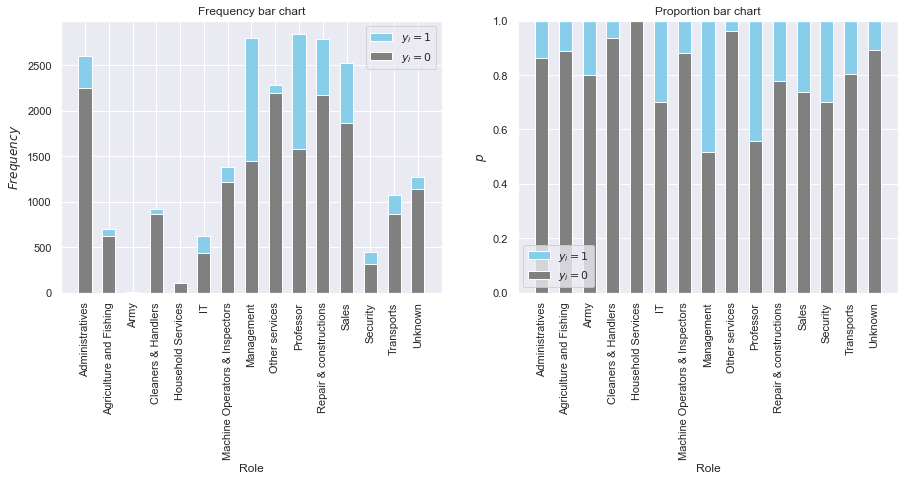

In [71]:
bar_charts_categorical(df_train, 'Role', "Income")

DATASETS TO WORK WITH FROM NOW ON:

In [72]:
df_train = df_outlier_train.copy()
df_test = df_outlier_test.copy()